In [1]:
import matplotlib.pyplot as plt
from math import ceil
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.ticker as mtick

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# using statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix
import pylab as py

# Links to custom datasets:
- https://fred.stlouisfed.org/graph/?g=1aA9K
- https://fred.stlouisfed.org/graph/?g=1aA9F


# Construction of Datasets

In [2]:
gov_transfer_payment = pd.read_csv('../data/gov_transfer_payments.csv')
gov_transfer_payment = gov_transfer_payment.rename(columns={'A084RC1Q027SBEA':'Gov_Transfer'})
gov_transfer_payment

,DATE,Gov_Transfer
0,1960-01-01,26.816
1,1960-04-01,28.228
2,1960-07-01,27.932
3,1960-10-01,29.572
4,1961-01-01,31.096
...,...,...
249,2022-04-01,3996.279
250,2022-07-01,4025.827
251,2022-10-01,4101.580
252,2023-01-01,4128.421


In [3]:
gov_transfer_payment_pct = pd.read_csv('../data/gov_transfer_payments_pct.csv')
gov_transfer_payment_pct = gov_transfer_payment_pct.rename(columns={'A084RC1Q027SBEA_PCH':'Gov_Transfer_PCH'})
gov_transfer_payment_pct

,DATE,Gov_Transfer_PCH
0,1947-04-01,0.18057
1,1947-07-01,36.80606
2,1947-10-01,-19.49934
3,1948-01-01,9.03437
4,1948-04-01,-2.13149
...,...,...
301,2022-07-01,0.73939
302,2022-10-01,1.88168
303,2023-01-01,0.65441
304,2023-04-01,0.37293


In [4]:
gdp_gov_spending = pd.read_csv('../data/fredgraph.csv')
gdp_gov_spending = gdp_gov_spending.rename(columns={'A939RX0Q048SBEA':'GDP_Per_Capita','FNDEFX':'NonDefense','FDEFX':'Defense','GCE':'Gov_Total','SLCE':'State_Local'})
gdp_gov_spending['DATE'] = pd.to_datetime(gdp_gov_spending['DATE'])
gdp_gov_spending['Gov_Transfer'] = gov_transfer_payment['Gov_Transfer']
gdp_gov_spending['Gov_Total'] = gdp_gov_spending['Gov_Total'] + gdp_gov_spending['Gov_Transfer']
# air_quality["datetime"] = pd.to_datetime(air_quality["datetime"])

gdp_gov_spending

,DATE,GDP_Per_Capita,NonDefense,Defense,Gov_Total,State_Local,Gov_Transfer
0,1960-01-01,19614.0,10.957,60.024,143.767,45.970,26.816
1,1960-04-01,19392.0,11.544,59.522,146.608,47.314,28.228
2,1960-07-01,19390.0,12.198,61.963,150.351,48.258,27.932
3,1960-10-01,19065.0,13.197,62.094,153.902,49.039,29.572
4,1961-01-01,19130.0,11.888,63.393,157.314,50.936,31.096
...,...,...,...,...,...,...,...
249,2022-04-01,65127.0,687.739,924.526,8411.955,2803.411,3996.279
250,2022-07-01,65462.0,705.922,930.402,8503.682,2841.530,4025.827
251,2022-10-01,65783.0,735.533,956.233,8673.988,2880.642,4101.580
252,2023-01-01,66078.0,761.926,968.723,8772.311,2913.242,4128.421


In [5]:
pct_change_gdp_gov = pd.read_csv('../data/pct_change_gdp_spending.csv')
pct_change_gdp_gov = pct_change_gdp_gov.rename(columns={'A939RX0Q048SBEA_PCH':'GDP_PC_PCH','FNDEFX_PCH':'NonDefense_PCH','FDEFX_PCH':'Defense_PCH','GCE_PCH':'Gov_Total_PCH','SLCE_PCH':'State_Local_PCH'})
pct_change_gdp_gov['DATE'] = pd.to_datetime(pct_change_gdp_gov['DATE'])
pct_change_gdp_gov['Gov_Transfer_PCH'] = gov_transfer_payment_pct['Gov_Transfer_PCH']

pct_change_gdp_gov

,DATE,GDP_PC_PCH,NonDefense_PCH,Defense_PCH,Gov_Total_PCH,State_Local_PCH,Gov_Transfer_PCH
0,1960-01-01,1.64801,-14.93012,-1.52897,-1.39704,2.67578,0.18057
1,1960-04-01,-1.13184,5.35731,-0.83633,1.22188,2.92365,36.80606
2,1960-07-01,-0.01031,5.66528,4.10100,3.41189,1.99518,-19.49934
3,1960-10-01,-1.67612,8.18987,0.21142,1.56103,1.61838,9.03437
4,1961-01-01,0.34094,-9.91892,2.09199,1.51854,3.86835,-2.13149
...,...,...,...,...,...,...,...
249,2022-04-01,-0.24354,-1.61862,2.42546,2.18151,3.07731,0.27754
250,2022-07-01,0.51438,2.64388,0.63557,1.40814,1.35974,0.02394
251,2022-10-01,0.49036,4.19466,2.77633,2.11157,1.37644,5.09608
252,2023-01-01,0.44844,3.58828,1.30617,1.56333,1.13169,0.26282


In [6]:
gdp_gov_spending.shape

(254, 7)

In [7]:
pct_change_gdp_gov.shape

(254, 7)

array([[<Axes: xlabel='GDP_Per_Capita', ylabel='GDP_Per_Capita'>,
        <Axes: xlabel='NonDefense', ylabel='GDP_Per_Capita'>,
        <Axes: xlabel='Defense', ylabel='GDP_Per_Capita'>,
        <Axes: xlabel='Gov_Total', ylabel='GDP_Per_Capita'>,
        <Axes: xlabel='State_Local', ylabel='GDP_Per_Capita'>,
        <Axes: xlabel='Gov_Transfer', ylabel='GDP_Per_Capita'>],
       [<Axes: xlabel='GDP_Per_Capita', ylabel='NonDefense'>,
        <Axes: xlabel='NonDefense', ylabel='NonDefense'>,
        <Axes: xlabel='Defense', ylabel='NonDefense'>,
        <Axes: xlabel='Gov_Total', ylabel='NonDefense'>,
        <Axes: xlabel='State_Local', ylabel='NonDefense'>,
        <Axes: xlabel='Gov_Transfer', ylabel='NonDefense'>],
       [<Axes: xlabel='GDP_Per_Capita', ylabel='Defense'>,
        <Axes: xlabel='NonDefense', ylabel='Defense'>,
        <Axes: xlabel='Defense', ylabel='Defense'>,
        <Axes: xlabel='Gov_Total', ylabel='Defense'>,
        <Axes: xlabel='State_Local', ylabel='Defense

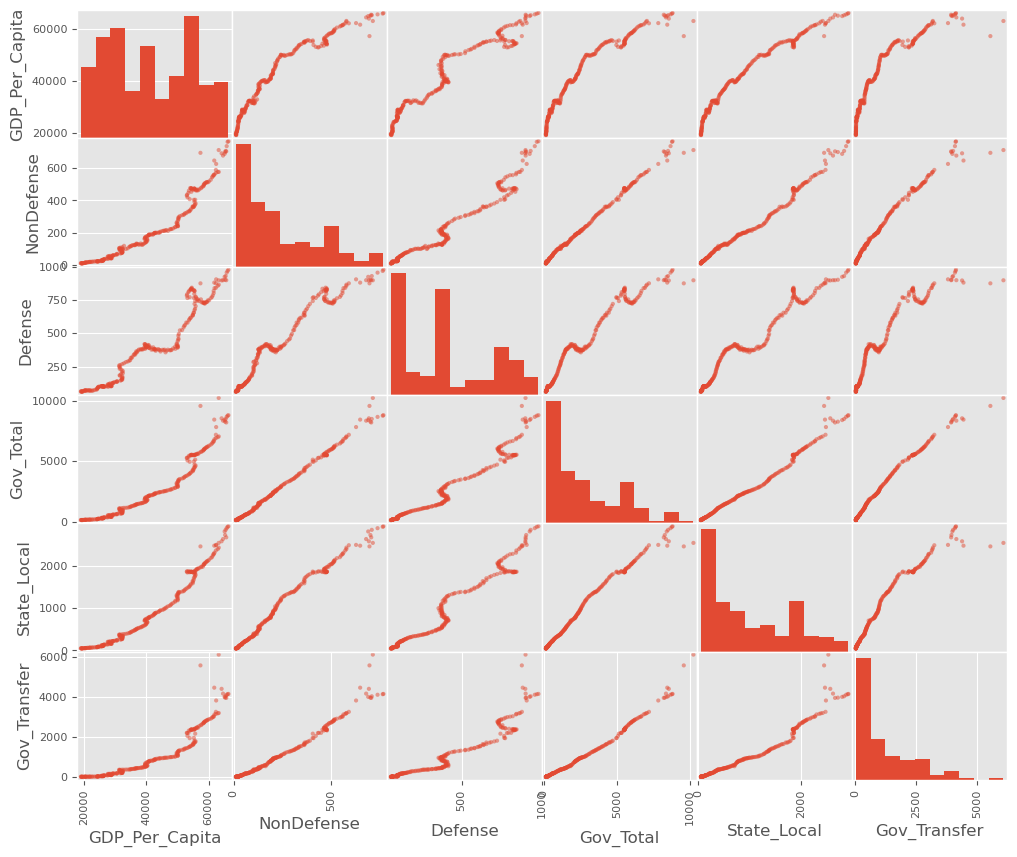

In [8]:
scatter_matrix(gdp_gov_spending, figsize=(12,10))

# Plotting the various subsets of the data to determine best approaches for visualization

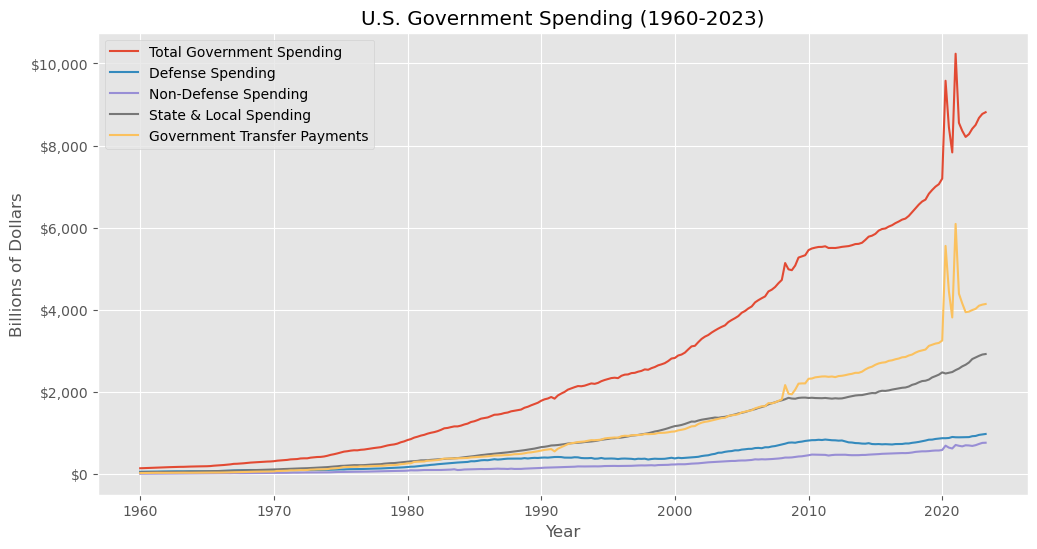

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
x=gdp_gov_spending['DATE']
total = gdp_gov_spending['Gov_Total']
defense = gdp_gov_spending['Defense']
nondefense = gdp_gov_spending['NonDefense']
state = gdp_gov_spending['State_Local']
transfer = gdp_gov_spending['Gov_Transfer']

ax.plot(x,total)
ax.plot(x,defense)
ax.plot(x,nondefense)
ax.plot(x, state)
ax.plot(x,transfer)

ax.legend(['Total Government Spending','Defense Spending','Non-Defense Spending', 'State & Local Spending','Government Transfer Payments'])
ax.set_title('U.S. Government Spending (1960-2023)')
ax.set_xlabel('Year')
ax.set_ylabel('Billions of Dollars')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

Text(0, 0.5, 'Percent Change')

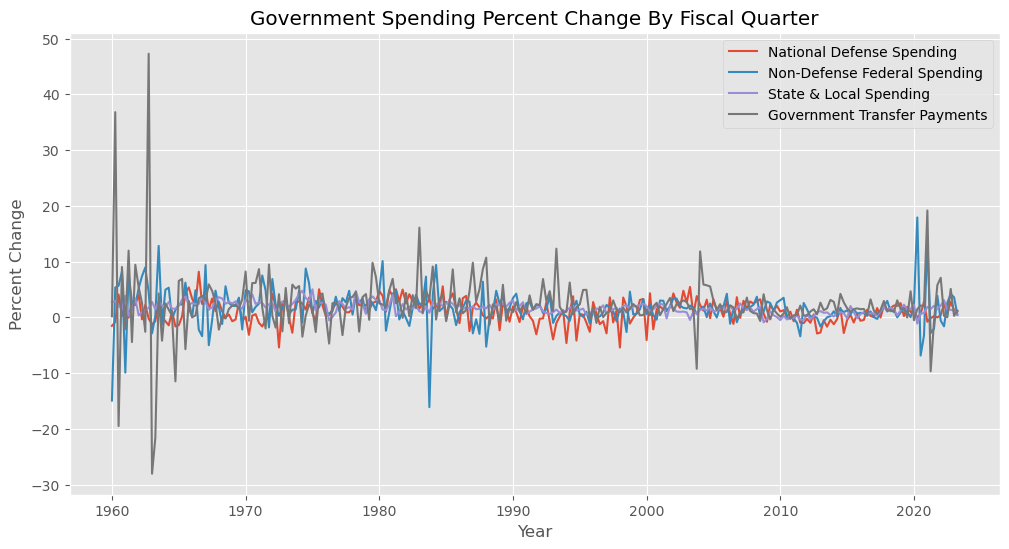

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
x2 = pct_change_gdp_gov['DATE']

gdp_pct = pct_change_gdp_gov['GDP_PC_PCH']
# total_pct = pct_change_gdp_gov['Gov_Total_PCH']
defense_pct = pct_change_gdp_gov['Defense_PCH']
nondefense_pct = pct_change_gdp_gov['NonDefense_PCH']
state_pct = pct_change_gdp_gov['State_Local_PCH']
transfer_pct = pct_change_gdp_gov['Gov_Transfer_PCH']

# ax.plot(x2,gdp_pct)
# ax.plot(x2,total_pct)
ax.plot(x2,defense_pct)
ax.plot(x2,nondefense_pct)
ax.plot(x2,state_pct)
ax.plot(x2,transfer_pct)

ax.legend(['National Defense Spending','Non-Defense Federal Spending', 'State & Local Spending','Government Transfer Payments'])
ax.set_title('Government Spending Percent Change By Fiscal Quarter')
ax.set_xlabel('Year')
ax.set_ylabel('Percent Change')

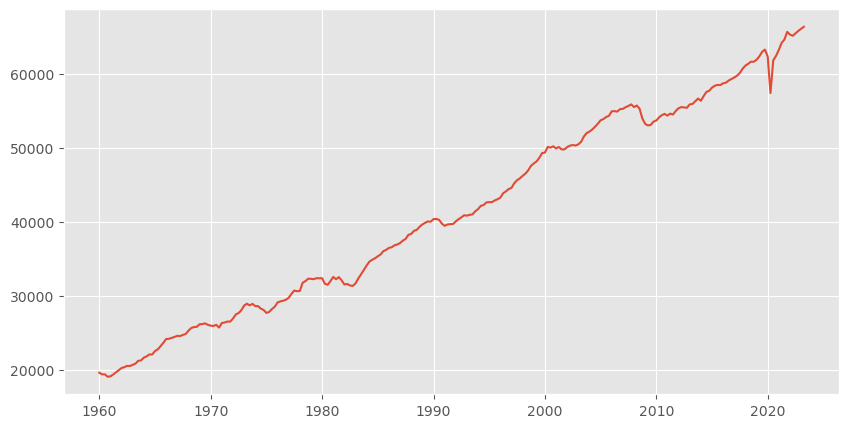

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
x=gdp_gov_spending['DATE']
gdp_per_cap = gdp_gov_spending['GDP_Per_Capita']
ax.plot(x,gdp_per_cap)
# ax2 = ax.twinx()


Text(0, 0.5, 'Percent Change')

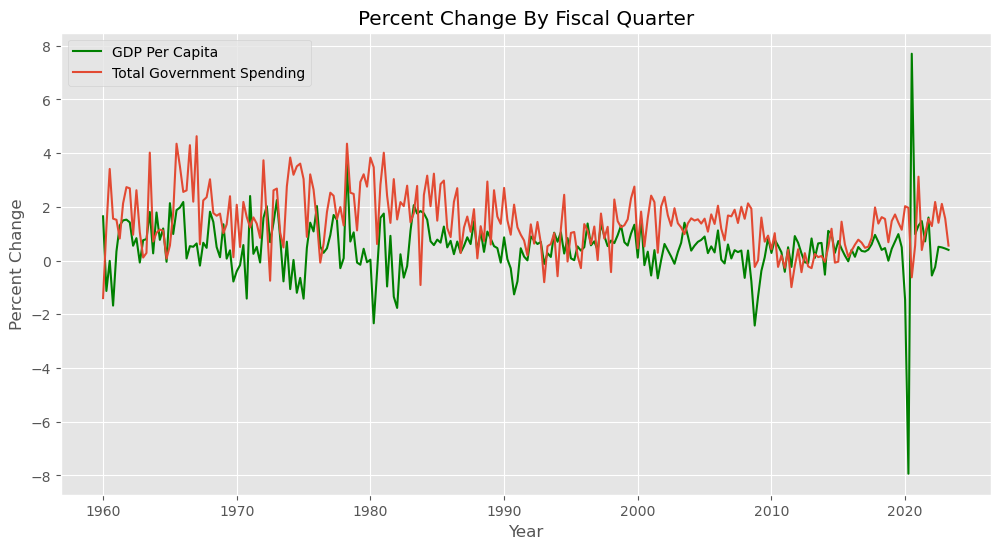

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
x2 = pct_change_gdp_gov['DATE']

gdp_pct = pct_change_gdp_gov['GDP_PC_PCH']
total_pct = pct_change_gdp_gov['Gov_Total_PCH']
# defense_pct = pct_change_gdp_gov['Defense_PCH']
# nondefense_pct = pct_change_gdp_gov['NonDefense_PCH']
# state_pct = pct_change_gdp_gov['State_Local_PCH']

ax.plot(x2,gdp_pct,color='green')
ax.plot(x2,total_pct)
# ax.plot(x2,defense_pct)
# ax.plot(x2,nondefense_pct)
# ax.plot(x2,state_pct)

ax.legend(['GDP Per Capita','Total Government Spending','Defense Spending','Non-Defense Spending', 'State & Local Spending'])
ax.set_title('Percent Change By Fiscal Quarter')
ax.set_xlabel('Year')
ax.set_ylabel('Percent Change')

Text(0, 0.5, 'Percent Change')

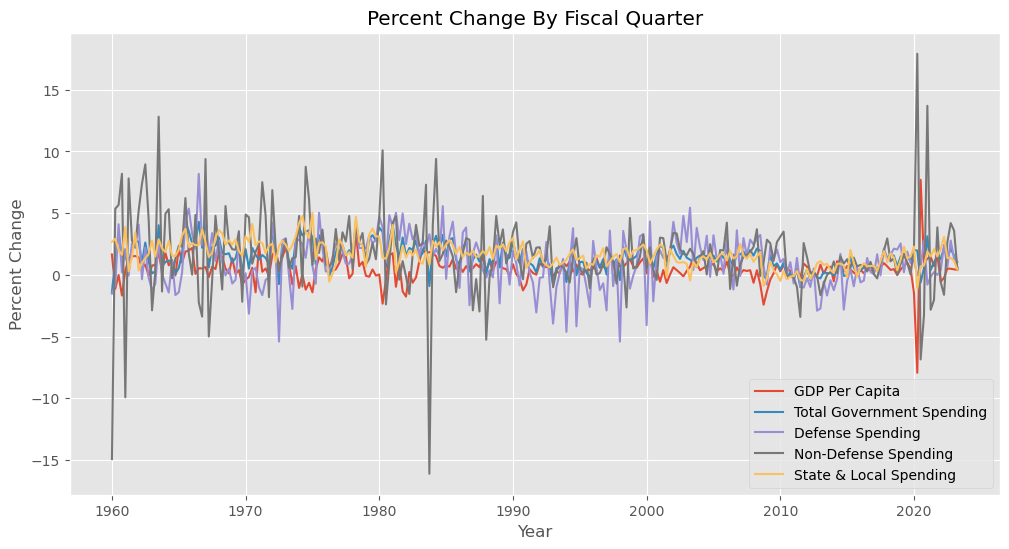

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
x2 = pct_change_gdp_gov['DATE']

gdp_pct = pct_change_gdp_gov['GDP_PC_PCH']
total_pct = pct_change_gdp_gov['Gov_Total_PCH']
defense_pct = pct_change_gdp_gov['Defense_PCH']
nondefense_pct = pct_change_gdp_gov['NonDefense_PCH']
state_pct = pct_change_gdp_gov['State_Local_PCH']

ax.plot(x2,gdp_pct)
ax.plot(x2,total_pct)
ax.plot(x2,defense_pct)
ax.plot(x2,nondefense_pct)
ax.plot(x2,state_pct)

ax.legend(['GDP Per Capita','Total Government Spending','Defense Spending','Non-Defense Spending', 'State & Local Spending'])
ax.set_title('Percent Change By Fiscal Quarter')
ax.set_xlabel('Year')
ax.set_ylabel('Percent Change')

In [14]:
# fig, ax = plt.subplots(figsize=(10,5))
# x2 = pct_change_gdp_gov['DATE']

# gdp_pct = pct_change_gdp_gov['GDP_PC_PCH']
# # total_pct = pct_change_gdp_gov['Gov_Total_PCH']
# defense_pct = pct_change_gdp_gov['Defense_PCH']
# nondefense_pct = pct_change_gdp_gov['NonDefense_PCH']
# state_pct = pct_change_gdp_gov['State_Local_PCH']
# transfer_pct = pct_change_gdp_gov['Gov_Transfer_PCH']

# ax.scatter(x2,gdp_pct)
# # ax.plot(x2,total_pct)
# ax.scatter(x2,defense_pct)
# ax.scatter(x2,nondefense_pct)
# ax.scatter(x2,state_pct)
# ax.scatter(x2,transfer_pct)

# ax.legend(['GDP Per Capita','Defense Spending','Non-Defense Spending', 'State & Local Spending','Government Transfer Payments'])
# ax.set_title('Percent Change By Fiscal Quarter')
# ax.set_xlabel('Year')
# ax.set_ylabel('Percent Change')

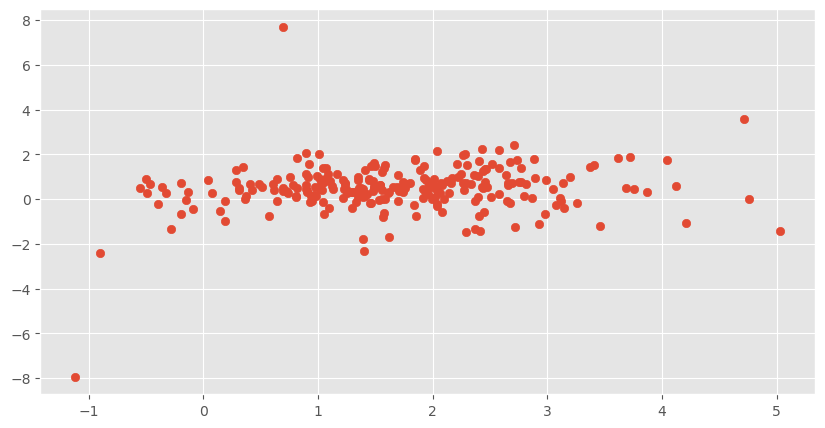

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
x2 = pct_change_gdp_gov['DATE']

gdp_pct = pct_change_gdp_gov['GDP_PC_PCH']
total_pct = pct_change_gdp_gov['Gov_Total_PCH']
defense_pct = pct_change_gdp_gov['Defense_PCH']
nondefense_pct = pct_change_gdp_gov['NonDefense_PCH']
state_pct = pct_change_gdp_gov['State_Local_PCH']

ax.scatter(state_pct,gdp_pct)
# ax.plot(x2,defense_pct)
# ax.plot(x2,nondefense_pct)
# ax.plot(x2,state_pct)

# ax.legend(['GDP Per Capita','Total Government Spending','Defense Spending','Non-Defense Spending', 'State & Local Spending'])
# ax.set_title('Percent Change By Fiscal Quarter')
# ax.set_xlabel('Year')
# ax.set_ylabel('Percent Change')

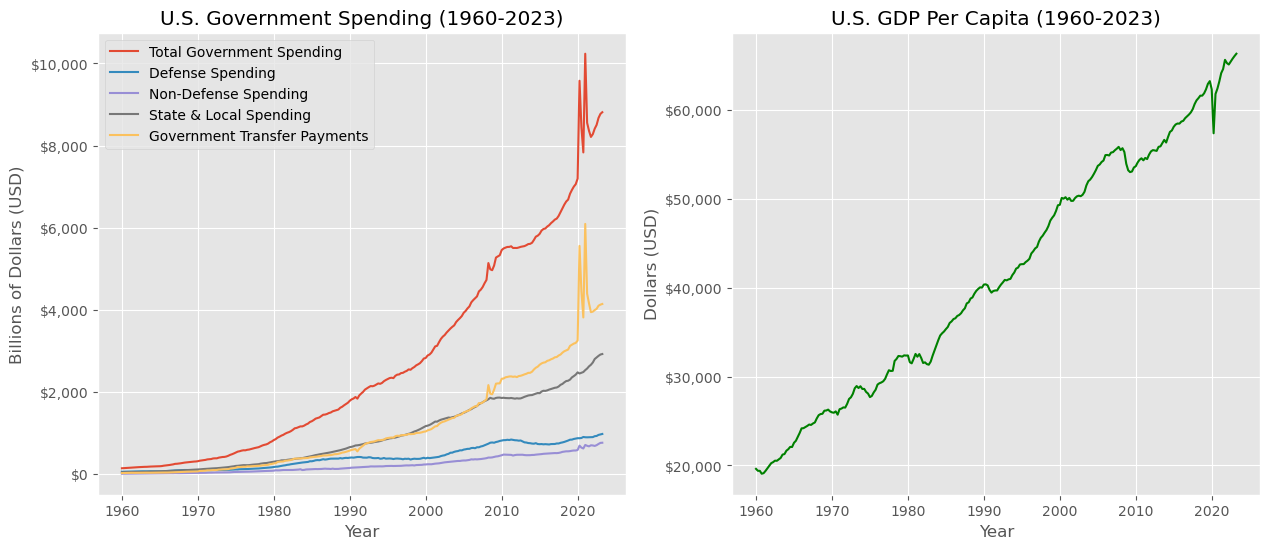

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
x=gdp_gov_spending['DATE']
total = gdp_gov_spending['Gov_Total']
defense = gdp_gov_spending['Defense']
nondefense = gdp_gov_spending['NonDefense']
state = gdp_gov_spending['State_Local']
transfer = gdp_gov_spending['Gov_Transfer']

ax[0].plot(x,total)
ax[0].plot(x,defense)
ax[0].plot(x,nondefense)
ax[0].plot(x, state)
ax[0].plot(x,transfer)

ax[0].legend(['Total Government Spending','Defense Spending','Non-Defense Spending', 'State & Local Spending','Government Transfer Payments'])
ax[0].set_title('U.S. Government Spending (1960-2023)')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Billions of Dollars (USD)')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax[0].yaxis.set_major_formatter(tick)
######################################################################
x=gdp_gov_spending['DATE']
gdp_per_cap = gdp_gov_spending['GDP_Per_Capita']
ax[1].plot(x,gdp_per_cap, color='green')

ax[1].set_title('U.S. GDP Per Capita (1960-2023)')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Dollars (USD)')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax[1].yaxis.set_major_formatter(tick)

Text(0, 0.5, 'Percent Change')

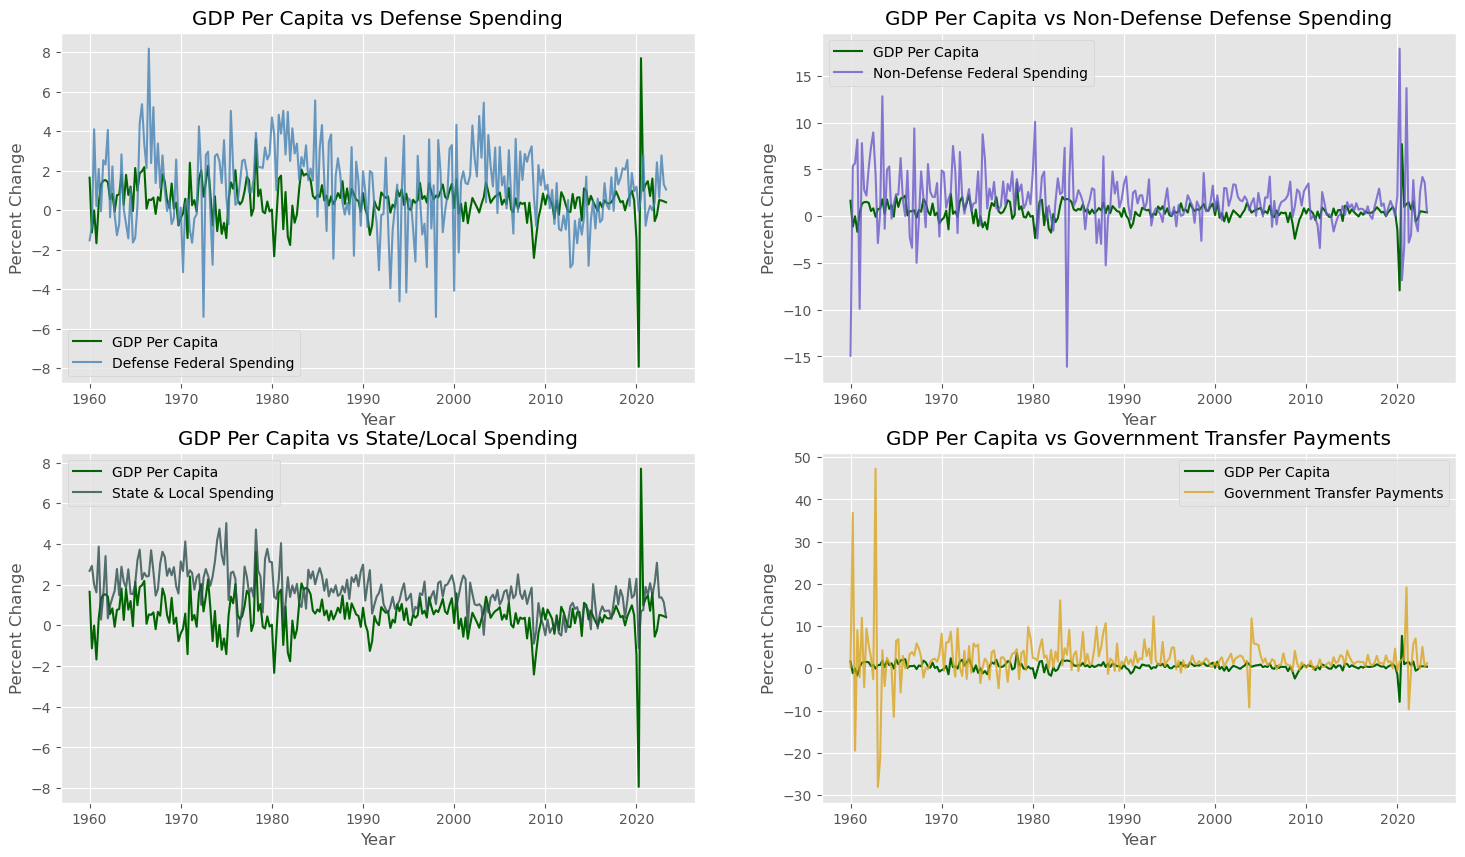

In [17]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(18,10))
x2 = pct_change_gdp_gov['DATE']

gdp_pct = pct_change_gdp_gov['GDP_PC_PCH']
# total_pct = pct_change_gdp_gov['Gov_Total_PCH']
defense_pct = pct_change_gdp_gov['Defense_PCH']
nondefense_pct = pct_change_gdp_gov['NonDefense_PCH']
state_pct = pct_change_gdp_gov['State_Local_PCH']
transfer_pct = pct_change_gdp_gov['Gov_Transfer_PCH']
#############################################################
ax[0][0].plot(x2,gdp_pct, color='darkgreen')
ax[0][0].plot(x2,defense_pct, color='steelblue',alpha=.8)

ax[0][0].legend(['GDP Per Capita','Defense Federal Spending'])
ax[0][0].set_title('GDP Per Capita vs Defense Spending')
ax[0][0].set_xlabel('Year')
ax[0][0].set_ylabel('Percent Change')
#############################################################
ax[0][1].plot(x2,gdp_pct, color='darkgreen')
ax[0][1].plot(x2,nondefense_pct, color='slateblue',alpha=.8)

ax[0][1].legend(['GDP Per Capita','Non-Defense Federal Spending'])
ax[0][1].set_title('GDP Per Capita vs Non-Defense Defense Spending')
ax[0][1].set_xlabel('Year')
ax[0][1].set_ylabel('Percent Change')
#############################################################
ax[1][0].plot(x2,gdp_pct, color='darkgreen')
ax[1][0].plot(x2,state_pct, color='darkslategrey',alpha=.8)

ax[1][0].legend(['GDP Per Capita','State & Local Spending'])
ax[1][0].set_title('GDP Per Capita vs State/Local Spending')
ax[1][0].set_xlabel('Year')
ax[1][0].set_ylabel('Percent Change')
#############################################################
ax[1][1].plot(x2,gdp_pct, color='darkgreen')
ax[1][1].plot(x2,transfer_pct, color='goldenrod',alpha=.8)


ax[1][1].legend(['GDP Per Capita','Government Transfer Payments'])
ax[1][1].set_title('GDP Per Capita vs Government Transfer Payments')
ax[1][1].set_xlabel('Year')
ax[1][1].set_ylabel('Percent Change')

Text(0, 0.5, 'Percent Change')

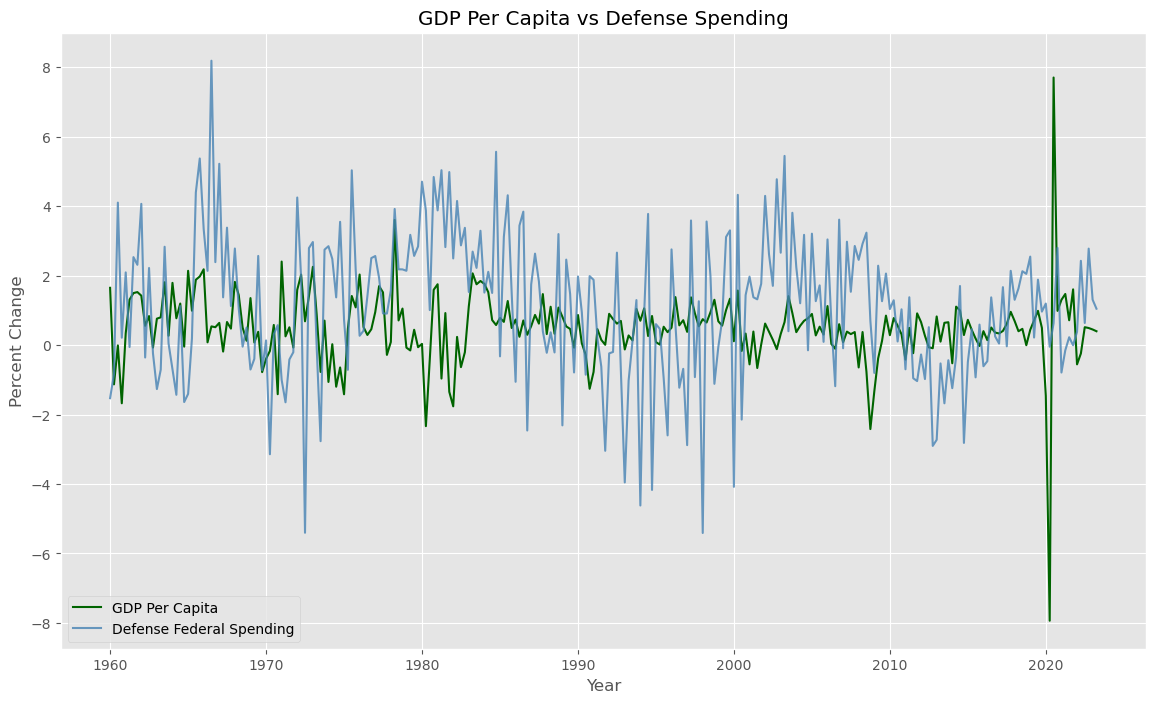

In [18]:
fig, ax = plt.subplots(figsize=(14,8))
x2 = pct_change_gdp_gov['DATE']

gdp_pct = pct_change_gdp_gov['GDP_PC_PCH']
# total_pct = pct_change_gdp_gov['Gov_Total_PCH']
defense_pct = pct_change_gdp_gov['Defense_PCH']
nondefense_pct = pct_change_gdp_gov['NonDefense_PCH']
state_pct = pct_change_gdp_gov['State_Local_PCH']
transfer_pct = pct_change_gdp_gov['Gov_Transfer_PCH']
#############################################################
ax.plot(x2,gdp_pct, color='darkgreen')
ax.plot(x2,defense_pct, color='steelblue',alpha=.8)

ax.legend(['GDP Per Capita','Defense Federal Spending'])
ax.set_title('GDP Per Capita vs Defense Spending')
ax.set_xlabel('Year')
ax.set_ylabel('Percent Change')
#############################################################


# Examining potential of the Percent Change Dataset 

In [19]:
# X = pct_change_gdp_gov[['Gov_Total_PCH']]
# y = pct_change_gdp_gov['GDP_PC_PCH']

# X = sm.add_constant(X)

# simple_model = sm.OLS(y,X).fit()
# simple_predictions = simple_model.predict(X)

# print_simple_table = simple_model.summary()
# print(print_simple_table)

In [20]:
X2 = pct_change_gdp_gov[['Defense_PCH','NonDefense_PCH','State_Local_PCH','Gov_Transfer_PCH']]
y2 = pct_change_gdp_gov['GDP_PC_PCH']

X2 = sm.add_constant(X2)

multi_model = sm.OLS(y2,X2).fit()
multi_predictions = multi_model.predict(X2)

print_multi_table = multi_model.summary()
print(print_multi_table)

                            OLS Regression Results                            
Dep. Variable:             GDP_PC_PCH   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     5.719
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           0.000203
Time:                        07:44:12   Log-Likelihood:                -365.91
No. Observations:                 254   AIC:                             741.8
Df Residuals:                     249   BIC:                             759.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3032      0.127  

In [21]:
# coeffs = multi_model.params
# coeffs[1]
# type(coeffs)

In [22]:
gdp_gov_spending.columns

Index(['DATE', 'GDP_Per_Capita', 'NonDefense', 'Defense', 'Gov_Total',
       'State_Local', 'Gov_Transfer'],
      dtype='object')

# Log transforming dataset to examine the effects on a regression model

In [23]:
log_gdp_gov_spending = gdp_gov_spending.copy()
log_gdp_gov_spending['Log_GDP_Per_Capita'] = np.log(log_gdp_gov_spending['GDP_Per_Capita'])
log_gdp_gov_spending['NonDefense'] = np.log(log_gdp_gov_spending['NonDefense'])
log_gdp_gov_spending['Defense'] = np.log(log_gdp_gov_spending['Defense'])
log_gdp_gov_spending['Gov_Total'] = np.log(log_gdp_gov_spending['Gov_Total'])
log_gdp_gov_spending['State_Local'] = np.log(log_gdp_gov_spending['State_Local'])
log_gdp_gov_spending['Gov_Transfer'] = np.log(log_gdp_gov_spending['Gov_Transfer'])
log_gdp_gov_spending

,DATE,GDP_Per_Capita,NonDefense,Defense,Gov_Total,State_Local,Gov_Transfer,Log_GDP_Per_Capita
0,1960-01-01,19614.0,2.393979,4.094744,4.968194,3.827989,3.288999,9.883999
1,1960-04-01,19392.0,2.446166,4.086346,4.987762,3.856806,3.340314,9.872616
2,1960-07-01,19390.0,2.501272,4.126537,5.012973,3.876562,3.329773,9.872513
3,1960-10-01,19065.0,2.579990,4.128649,5.036316,3.892616,3.386828,9.855609
4,1961-01-01,19130.0,2.475529,4.149353,5.058244,3.930570,3.437079,9.859013
...,...,...,...,...,...,...,...,...
249,2022-04-01,65127.0,6.533409,6.829281,9.037409,7.938592,8.293119,11.084094
250,2022-07-01,65462.0,6.559505,6.835617,9.048255,7.952098,8.300486,11.089225
251,2022-10-01,65783.0,6.600595,6.863002,9.068084,7.965768,8.319128,11.094117
252,2023-01-01,66078.0,6.635849,6.875979,9.079356,7.977022,8.325650,11.098591


# Simple Money Model; GDP Per Capita Vs Total Government Spending

In [24]:
X5 = gdp_gov_spending[['Gov_Total']]
y5 = gdp_gov_spending['GDP_Per_Capita']

X5 = sm.add_constant(X5)

simple_money_model = sm.OLS(y5,X5).fit()
simple_money_predictions = simple_money_model.predict(X5)

print_simple_money_table = simple_money_model.summary()
print(print_simple_money_table)

                            OLS Regression Results                            
Dep. Variable:         GDP_Per_Capita   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     2180.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          4.64e-126
Time:                        07:44:12   Log-Likelihood:                -2489.5
No. Observations:                 254   AIC:                             4983.
Df Residuals:                     252   BIC:                             4990.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.722e+04    409.430     66.477      0.0

# Simple Log Model; Log of GDP Per Capita vs Total Government Spending

In [25]:
X6 = log_gdp_gov_spending[['Gov_Total']]
y6 = log_gdp_gov_spending['Log_GDP_Per_Capita']

X6 = sm.add_constant(X6)

simple_log_model = sm.OLS(y6,X6).fit()
simple_log_predictions = simple_log_model.predict(X6)

print_simple_log_table = simple_log_model.summary()
print(print_simple_log_table)

                            OLS Regression Results                            
Dep. Variable:     Log_GDP_Per_Capita   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.635e+04
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          3.52e-231
Time:                        07:44:12   Log-Likelihood:                 438.01
No. Observations:                 254   AIC:                            -872.0
Df Residuals:                     252   BIC:                            -864.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4825      0.017    512.049      0.0

# Complex Model; GDP Per Capita vs Breakdown of Government Spending

In [26]:
X3 = gdp_gov_spending[['Defense','NonDefense','State_Local','Gov_Transfer']]
y3 = gdp_gov_spending['GDP_Per_Capita']

X3 = sm.add_constant(X3)

money_model = sm.OLS(y3,X3).fit()
money_predictions = money_model.predict(X3)

money_residuals = money_model.resid

print_money_table = money_model.summary()
print(print_money_table)



# Coefficients read as individual dollar effect on GDP per capita for each billion dollars spent per category

                            OLS Regression Results                            
Dep. Variable:         GDP_Per_Capita   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1893.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          5.08e-185
Time:                        07:44:12   Log-Likelihood:                -2339.6
No. Observations:                 254   AIC:                             4689.
Df Residuals:                     249   BIC:                             4707.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.401e+04    340.361     70.535   

# Complex Log Model; Log of GDP Per Capita vs Breakdown of Government Spending

In [27]:

X4 = gdp_gov_spending[['Defense','NonDefense','State_Local','Gov_Transfer']]
y4 = log_gdp_gov_spending['Log_GDP_Per_Capita']

X4 = sm.add_constant(X4)

log_model = sm.OLS(y4,X4).fit()
log_predictions = log_model.predict(X4)

print_log_table = log_model.summary()
print(print_log_table)

                            OLS Regression Results                            
Dep. Variable:     Log_GDP_Per_Capita   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     682.6
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          7.26e-133
Time:                        07:44:12   Log-Likelihood:                 221.38
No. Observations:                 254   AIC:                            -432.8
Df Residuals:                     249   BIC:                            -415.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.0992      0.014    709.972   

In [28]:
gdp_gov_spending['GDP_Per_Capita']

0      19614.0
1      19392.0
2      19390.0
3      19065.0
4      19130.0
        ...   
249    65127.0
250    65462.0
251    65783.0
252    66078.0
253    66341.0
Name: GDP_Per_Capita, Length: 254, dtype: float64

Text(0, 0.5, 'GDPpc % Change')

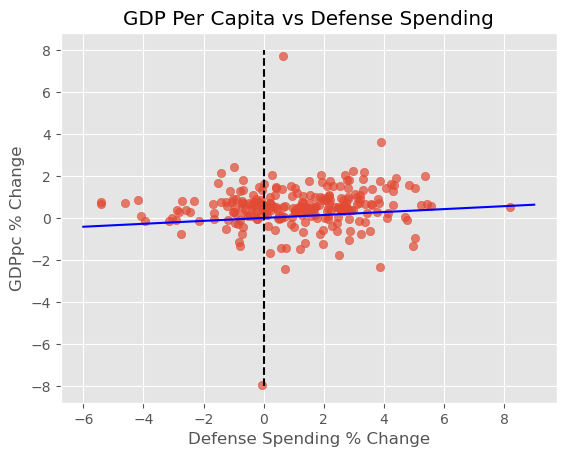

In [29]:
fig, ax = plt.subplots()
natdef = pct_change_gdp_gov['Defense_PCH']
gdppc = pct_change_gdp_gov['GDP_PC_PCH']
ax.scatter(natdef, gdppc,alpha=.7)
ax.plot(np.linspace(-6,9,9),.07*np.linspace(-6,9,9), color='blue')
ax.vlines(0,-8,8, linestyles='--',color='black')


ax.set_title('GDP Per Capita vs Defense Spending')
ax.set_xlabel('Defense Spending % Change')
ax.set_ylabel('GDPpc % Change')


## Need to write a function that takes the coefficients and transforms them into a legible interpretation of the results!

In [30]:
# coeffs = money_model.params
# coeffs[1]

# coeff_list = []
# for i in coeffs:
#     coeff_list.append(coeffs[i+1])


In [33]:
gdp_gov_spending.to_csv('../cleaned_data/gdp_gov_spending.csv',index=False)
log_gdp_gov_spending.to_csv('../cleaned_data/log_gdp_gov_spending.csv',index=False)
pct_change_gdp_gov.to_csv('../cleaned_data/pct_change_gdp_gov.csv',index=False)